# FinRL: Compare ElegantRL, RLlib, and Stablebaselines3

## Install DRL libraries: FinRL, ElegantRL, RLlib

In [1]:
## install elegantrl library
!pip install git+https://github.com/AI4Finance-LLC/ElegantRL.git
## install rllib/ray library
!pip install ray[default]
## install finrl library
!pip install git+https://github.com/AI4Finance-LLC/FinRL-Library.git

  Cloning https://github.com/AI4Finance-LLC/ElegantRL.git to /tmp/pip-req-build-mz9cp11m
  Running command git clone -q https://github.com/AI4Finance-LLC/ElegantRL.git /tmp/pip-req-build-mz9cp11m
     |████████████████████████████████| 89.3 MB 19 kB/s 
     |████████████████████████████████| 448 kB 38.1 MB/s 
  Created wheel for elegantrl: filename=elegantrl-0.3.1-py3-none-any.whl size=72851 sha256=8bf898ae82c59de100c45d2dcfce89e01d5add3c1b554ae5e6220ffcd677b7b4
  Stored in directory: /tmp/pip-ephem-wheel-cache-lsnsahi4/wheels/52/9a/b3/08c8a0b5be22a65da0132538c05e7e961b1253c90d6845e0c6
Successfully built elegantrl
     |████████████████████████████████| 54.0 MB 75 kB/s 
     |████████████████████████████████| 72 kB 646 kB/s 
     |████████████████████████████████| 65 kB 4.0 MB/s 
     |████████████████████████████████| 78 kB 7.9 MB/s 
     |████████████████████████████████| 201 kB 47.0 MB/s 
     |████████████████████████████████| 3.2 MB 46.8 MB/s 
     |███████████████████████████████

## Install additional packages

In [2]:
!pip install trading_calendars
!pip install alpaca_trade_api
!pip install ccxt
!pip install jqdatasdk
!pip install wrds

!pip install lz4
!pip install ray[tune]
!pip install tensorboardX
!pip install gputil

## Import packages

In [3]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# matplotlib.use('Agg')
import datetime

from elegantrl.agent import *
from elegantrl.run import *
import torch 
import ray
from finrl.apps import config
from finrl.neo_finrl.data_processor import DataProcessor
from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline



/usr/local/lib/python3.7/dist-packages/pyfolio/pos.py:27: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  'Module "zipline.assets" not found; multipliers will not be applied'


## Train

In [4]:
def train(start_date, end_date, ticker_list, data_source, time_interval, 
          technical_indicator_list, drl_lib, env, agent, if_vix = True,
          **kwargs):
    
    #fetch data
    DP = DataProcessor(data_source, **kwargs)
    data = DP.download_data(ticker_list, start_date, end_date, time_interval)
    data = DP.clean_data(data)
    data = DP.add_technical_indicator(data, technical_indicator_list)
    if if_vix:
        data = DP.add_vix(data)
    price_array, tech_array, turbulence_array = DP.df_to_array(data, if_vix)
    
    #read parameters
    env_config = {'price_array':price_array,
            'tech_array':tech_array,
            'turbulence_array':turbulence_array,
            'if_train':True}
    env_instance = env(config=env_config)
    
    learning_rate = kwargs.get('learning_rate', 2 ** -15)
    batch_size = kwargs.get('batch_size', 2 ** 11 )
    gamma = kwargs.get('gamma', 0.99)
    seed = kwargs.get('seed', 312)
    total_timesteps = kwargs.get('total_timesteps', 1e6)
    net_dimension = kwargs.get('net_dimension', 2**9)
    cwd = kwargs.get('cwd','./'+str(agent))
    
    #train using different libraries
    if drl_lib == 'elegantrl':
        
        if agent == 'ppo':
            args = Arguments(if_on_policy=True)
            args.agent = AgentPPO()
            args.env = env_instance
            args.agent.if_use_cri_target = True
            args.cwd = cwd
        else:
            raise ValueError('Invalid agent input or the agent input is not \
                             supported yet.')
        try:
            args.learning_rate = learning_rate
            args.batch_size = batch_size
            args.gamma = gamma
            args.seed = seed
            args.break_step = total_timesteps
            args.net_dimension = net_dimension
        except:
            print('Invalid parameters input! Use default value.')
            args.learning_rate = 2 ** -15
            args.batch_size = 2 ** 11
            args.gamma = 0.99
            args.seed = 312
            args.break_step = 1e6
            args.net_dimension = 2**9
            
        train_and_evaluate(args)
        
    elif drl_lib == 'rllib':
        ray.init(ignore_reinit_error=True)
        if agent == 'ppo':
            from ray.rllib.agents import ppo
            from ray.rllib.agents.ppo.ppo import PPOTrainer
            try:
                total_episodes = kwargs.get('total_episodes')
            except:
                print('total training episodes is not given! Use default value 1000')
                total_episodes = 1000
            config = ppo.DEFAULT_CONFIG.copy()
            config['lr'] = learning_rate
            config['train_batch_size'] = batch_size
            config['gamma'] = gamma
            config['env'] = env
            config['log_level'] = "WARN"
            config['env_config'] = {'price_array':price_array,
                                    'tech_array':tech_array,
                                    'turbulence_array':turbulence_array,
                                    'if_train':True}
            trainer = PPOTrainer(env=env, config=config)
            for i in range(total_episodes):
                trainer.train()
            trainer.save(cwd)
        
        else:
            raise ValueError('Invalid agent input or the agent input is not \
                 supported yet.')
            
    elif drl_lib == 'stable_baselines3':
        
        if agent == 'ppo':
            from stable_baselines3 import PPO
            from stable_baselines3.common.vec_env import DummyVecEnv
            
            env_train = DummyVecEnv([lambda : env_instance])
            model = PPO("MlpPolicy", env_train, learning_rate=learning_rate, 
                        n_steps=2048, batch_size=batch_size, ent_coef=0.0, 
                        gamma=gamma, seed=seed)
            model.learn(total_timesteps=total_timesteps, tb_log_name = 'ppo')
            print('Training finished!')
            model.save(cwd)
            print('Trained model saved in ' + str(cwd))
    
    else:
        raise ValueError('DRL library input is NOT supported. Please check.')

## Test

In [6]:
def test(start_date, end_date, ticker_list, data_source, time_interval, 
         technical_indicator_list, drl_lib, env, agent, if_vix = True,
         **kwargs):
    #fetch data
    DP = DataProcessor(data_source, **kwargs)
    data = DP.download_data(ticker_list, start_date, end_date, time_interval)
    data = DP.clean_data(data)
    data = DP.add_technical_indicator(data, technical_indicator_list)

    if if_vix:
        data = DP.add_vix(data)
    price_array, tech_array, turbulence_array = DP.df_to_array(data, if_vix)
    
    env_config = {'price_array':price_array,
            'tech_array':tech_array,
            'turbulence_array':turbulence_array,
            'if_train':False}
    env_instance = env(config=env_config)
    
    net_dimension = kwargs.get('net_dimension', 2**7)
    cwd = kwargs.get('cwd','./'+str(agent))
    print("price_array: ",len(price_array))
    #test on elegantrl
    if drl_lib == 'elegantrl':
        
        #select agent
        if agent == 'ppo':
            args = Arguments(if_on_policy=True)
            args.agent = AgentPPO()
            args.env = env_instance
            args.agent.if_use_cri_target = True
        else:
            raise ValueError('Invalid agent input or the agent input is not \
                             supported yet.')
        
        #load agent
        try:
            state_dim = env_instance.state_dim
            action_dim = env_instance.action_dim
    
            agent = args.agent
            net_dim = net_dimension
    
            agent.init(net_dim, state_dim, action_dim)
            agent.save_or_load_agent(cwd=cwd, if_save=False)
            act = agent.act
            device = agent.device
    
        except:
            raise ValueError('Fail to load agent!')
        
        #test on the testing env
        _torch = torch
        state = env_instance.reset()
        episode_returns = list()  # the cumulative_return / initial_account
        episode_total_assets = list()
        episode_total_assets.append(env_instance.initial_total_asset)
        with _torch.no_grad():
            for i in range(env_instance.max_step):
                s_tensor = _torch.as_tensor((state,), device=device)
                a_tensor = act(s_tensor)  # action_tanh = act.forward()
                action = a_tensor.detach().cpu().numpy()[0]  # not need detach(), because with torch.no_grad() outside
                state, reward, done, _ = env_instance.step(action)

                total_asset = env_instance.amount + (env_instance.price_ary[env_instance.day] * env_instance.stocks).sum()
                episode_total_assets.append(total_asset)
                episode_return = total_asset / env_instance.initial_total_asset
                episode_returns.append(episode_return)
                if done:
                    break
                ##print(i)
        print('Test Finished!')
        #return episode returns on testing data
        print('episode_return', episode_return)
        return episode_total_assets
    
    #test using rllib
    elif drl_lib == 'rllib':
        #load agent
        from ray.rllib.agents import ppo
        from ray.rllib.agents.ppo.ppo import PPOTrainer
        config = ppo.DEFAULT_CONFIG.copy()
        config['env'] = env
        config["log_level"] = "WARN"
        config['env_config'] = {'price_array':price_array,
                                'tech_array':tech_array,
                                'turbulence_array':turbulence_array,
                                'if_train':False}
        
        trainer = PPOTrainer(env=env, config=config)
        try:
            trainer.restore(cwd)
            print("Restoring from checkpoint path", cwd)
        except:
            raise ValueError('Fail to load agent!')
        
        #test on the testing env
        state = env_instance.reset()
        episode_returns = list()  # the cumulative_return / initial_account
        episode_total_assets = list()
        episode_total_assets.append(env_instance.initial_total_asset)
        done = False
        while not done:
            action = trainer.compute_single_action(state)
            state, reward, done, _ = env_instance.step(action)
    
            total_asset = env_instance.amount + (env_instance.price_ary[env_instance.day] * env_instance.stocks).sum()
            episode_total_assets.append(total_asset)
            episode_return = total_asset / env_instance.initial_total_asset
            episode_returns.append(episode_return)
        print('episode return: ' + str(episode_return))
        print('Test Finished!')   
        return episode_total_assets

          #test using stable baselines3
    elif drl_lib == 'stable_baselines3':
        from stable_baselines3 import PPO

        try:
            #load agent
            model = PPO.load(cwd)
            print("Successfully load model", cwd)
        except:
            raise ValueError('Fail to load agent!')
        
        #test on the testing env
        state = env_instance.reset()
        episode_returns = list()  # the cumulative_return / initial_account
        episode_total_assets = list()
        episode_total_assets.append(env_instance.initial_total_asset)
        done = False
        while not done:
            action = model.predict(state)[0]
            state, reward, done, _ = env_instance.step(action)
    
            total_asset = env_instance.amount + (env_instance.price_ary[env_instance.day] * env_instance.stocks).sum()
            episode_total_assets.append(total_asset)
            episode_return = total_asset / env_instance.initial_total_asset
            episode_returns.append(episode_return)
        
        print('episode_return', episode_return)
        print('Test Finished!')   
        return episode_total_assets
    
    else:
        raise ValueError('DRL library input is NOT supported yet. Please check.')

## DRL Environment

In [7]:
from finrl.neo_finrl.env_stock_trading.env_stocktrading_np import StockTradingEnv

In [8]:
import numpy as np
import os
import gym
from numpy import random as rd

class StockTradingEnv(gym.Env):

    def __init__(self, config, initial_account=1e6,
                 gamma=0.99, turbulence_thresh=99, min_stock_rate=0.1,
                 max_stock=1e2, initial_capital=1e6, buy_cost_pct=1e-3, 
                 sell_cost_pct=1e-3,reward_scaling=2 ** -11,  initial_stocks=None,
                 ):
        price_ary = config['price_array']
        tech_ary = config['tech_array']
        turbulence_ary = config['turbulence_array']
        if_train = config['if_train']
        n = price_ary.shape[0]
        self.price_ary =  price_ary.astype(np.float32)
        self.tech_ary = tech_ary.astype(np.float32)
        self.turbulence_ary = turbulence_ary
        
        self.tech_ary = self.tech_ary * 2 ** -7
        self.turbulence_bool = (turbulence_ary > turbulence_thresh).astype(np.float32)
        self.turbulence_ary = (self.sigmoid_sign(turbulence_ary, turbulence_thresh) * 2 ** -5).astype(np.float32)

        stock_dim = self.price_ary.shape[1]
        self.gamma = gamma
        self.max_stock = max_stock
        self.min_stock_rate = min_stock_rate
        self.buy_cost_pct = buy_cost_pct
        self.sell_cost_pct = sell_cost_pct
        self.reward_scaling = reward_scaling
        self.initial_capital = initial_capital
        self.initial_stocks = np.zeros(stock_dim, dtype=np.float32) if initial_stocks is None else initial_stocks

        # reset()
        self.day = None
        self.amount = None
        self.stocks = None
        self.total_asset = None
        self.gamma_reward = None
        self.initial_total_asset = None

        # environment information
        self.env_name = 'StockEnv'
        # self.state_dim = 1 + 2 + 2 * stock_dim + self.tech_ary.shape[1]
        # # amount + (turbulence, turbulence_bool) + (price, stock) * stock_dim + tech_dim
        self.state_dim = 1 + 2 + 3 * stock_dim + self.tech_ary.shape[1]
        # amount + (turbulence, turbulence_bool) + (price, stock) * stock_dim + tech_dim
        self.stocks_cd = None
        self.action_dim = stock_dim
        self.max_step = self.price_ary.shape[0] - 1
        self.if_train = if_train
        self.if_discrete = False
        self.target_return = 5.0
        self.episode_return = 0.0
        
        self.observation_space = gym.spaces.Box(low=-3000, high=3000, shape=(self.state_dim,), dtype=np.float32)
        self.action_space = gym.spaces.Box(low=-1, high=1, shape=(self.action_dim,), dtype=np.float32)
        
    def reset(self):
        self.day = 0
        price = self.price_ary[self.day]
        
        if self.if_train:
            self.stocks = (self.initial_stocks + rd.randint(0, 64, size=self.initial_stocks.shape)).astype(np.float32)
            self.stocks_cd = np.zeros_like(self.stocks)
            self.amount = self.initial_capital * rd.uniform(0.95, 1.05) - (self.stocks * price).sum()
        else:
            self.stocks = self.initial_stocks.astype(np.float32)
            self.stocks_cd = np.zeros_like(self.stocks)
            self.amount = self.initial_capital

        self.total_asset = self.amount + (self.stocks * price).sum()
        self.initial_total_asset = self.total_asset
        self.gamma_reward = 0.0
        return self.get_state(price)  # state

    def step(self, actions):
        actions = (actions * self.max_stock).astype(int)

        self.day += 1
        price = self.price_ary[self.day]
        self.stocks_cd += 1

        if self.turbulence_bool[self.day] == 0:
            min_action = int(self.max_stock * self.min_stock_rate)  # stock_cd
            for index in np.where(actions < -min_action)[0]:  # sell_index:
                if price[index] > 0:  # Sell only if current asset is > 0
                    sell_num_shares = min(self.stocks[index], -actions[index])
                    self.stocks[index] -= sell_num_shares
                    self.amount += price[index] * sell_num_shares * (1 - self.sell_cost_pct)
                    self.stocks_cd[index] = 0
            for index in np.where(actions > min_action)[0]:  # buy_index:
                if price[index] > 0:  # Buy only if the price is > 0 (no missing data in this particular date)
                    buy_num_shares = min(self.amount // price[index], actions[index])
                    self.stocks[index] += buy_num_shares
                    self.amount -= price[index] * buy_num_shares * (1 + self.buy_cost_pct)
                    self.stocks_cd[index] = 0

        else:  # sell all when turbulence
            self.amount += (self.stocks * price).sum() * (1 - self.sell_cost_pct)
            self.stocks[:] = 0
            self.stocks_cd[:] = 0

        state = self.get_state(price)
        total_asset = self.amount + (self.stocks * price).sum()
        reward = (total_asset - self.total_asset) * self.reward_scaling
        self.total_asset = total_asset

        self.gamma_reward = self.gamma_reward * self.gamma + reward
        done = self.day == self.max_step
        if done:
            reward = self.gamma_reward
            self.episode_return = total_asset / self.initial_total_asset

        return state, reward, done, dict()

    def get_state(self, price):
        amount = np.array(max(self.amount, 1e4) * (2 ** -12), dtype=np.float32)
        scale = np.array(2 ** -6, dtype=np.float32)
        return np.hstack((amount,
                          self.turbulence_ary[self.day],
                          self.turbulence_bool[self.day],
                          price * scale,
                          self.stocks * scale,
                          self.stocks_cd,
                          self.tech_ary[self.day],
                          ))  # state.astype(np.float32)
    
    @staticmethod
    def sigmoid_sign(ary, thresh):
        def sigmoid(x):
            return 1 / (1 + np.exp(-x * np.e)) - 0.5

        return sigmoid(ary / thresh) * thresh


## Set parameters

In [9]:
env = StockTradingEnv

In [10]:
TRAIN_START_DATE = '2014-01-01'
TRAIN_END_DATE = '2020-07-30'

TEST_START_DATE = '2020-08-01'
TEST_END_DATE = '2021-08-05'
TECHNICAL_INDICATORS_LIST = ['macd',
 'boll_ub',
 'boll_lb',
 'rsi_30',
 'dx_30',
 'close_30_sma',
 'close_60_sma']

## eRL

### Train

In [22]:
#demo for elegantrl
train(start_date = TRAIN_START_DATE, 
      end_date = TRAIN_END_DATE,
      ticker_list = config.DOW_30_TICKER, 
      data_source = 'yahoofinance',
      time_interval= '1D', 
      technical_indicator_list= TECHNICAL_INDICATORS_LIST,
      drl_lib='elegantrl', 
      env=env, 
      agent='ppo', 
      cwd='./test_ppo',
      gamma = 0.985
      ,total_timesteps=5e4)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

### Test

In [23]:
account_value_erl=test(start_date = TEST_START_DATE, 
                        end_date = TEST_END_DATE,
                        ticker_list = config.DOW_30_TICKER, 
                        data_source = 'yahoofinance',
                        time_interval= '1D', 
                        technical_indicator_list= TECHNICAL_INDICATORS_LIST,
                        drl_lib='elegantrl', 
                        env=env, 
                        agent='ppo', 
                        cwd='./test_ppo', 
                        net_dimension = 2 ** 9)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [24]:
len(account_value_erl)

255

### Plot

In [25]:
TEST_END_DATE

'2021-08-05'

In [26]:
baseline_df =  DataProcessor('yahoofinance').download_data(ticker_list = ["^DJI"], 
                                                            start_date = TEST_START_DATE, 
                                                            end_date = TEST_END_DATE, 
                                                            time_interval = "1D")
stats = backtest_stats(baseline_df, value_col_name = 'close')


[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (254, 9)
Annual return          0.302105
Cumulative returns     0.304836
Annual volatility      0.143039
Sharpe ratio           1.925145
Calmar ratio           3.382743
Stability              0.935738
Max drawdown          -0.089308
Omega ratio            1.381054
Sortino ratio          2.847623
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.074665
Daily value at risk   -0.016928
dtype: float64


In [27]:
account_value_erl = pd.DataFrame({'date':baseline_df.date,'account_value':account_value_erl[0:len(account_value_erl)-1]})

In [28]:
account_value_erl.tail()

,date,account_value
249,2021-07-29,1.423527e+06
250,2021-07-30,1.417160e+06
251,2021-08-02,1.423528e+06
252,2021-08-03,1.437051e+06
253,2021-08-04,1.427797e+06


In [29]:
print("==============Get Backtest Results===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

perf_stats_all = backtest_stats(account_value=account_value_erl)
perf_stats_all = pd.DataFrame(perf_stats_all)
perf_stats_all.to_csv("./"+"/perf_stats_all_"+now+'.csv')

==============Get Backtest Results===========
Annual return          0.423799
Cumulative returns     0.427797
Annual volatility      0.147032
Sharpe ratio           2.487340
Calmar ratio           5.299707
Stability              0.953489
Max drawdown          -0.079967
Omega ratio            1.521104
Sortino ratio          4.076649
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.192013
Daily value at risk   -0.017073
dtype: float64


==============Compare to DJIA===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (253, 8)


Start date,2020-08-03
End date,2021-08-04
Total months,12
,Backtest
Annual return,42.38%
Cumulative returns,42.78%
Annual volatility,14.703%
Sharpe ratio,2.49
Calmar ratio,5.30
Stability,0.95
Max drawdown,-7.997%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,8.00,2021-01-14,2021-01-29,2021-02-16,24
1,7.56,2021-06-04,2021-06-18,2021-08-03,43
2,5.44,2020-10-12,2020-10-30,2020-11-09,21
3,3.85,2021-05-07,2021-05-12,2021-05-27,15
4,3.29,2021-03-12,2021-03-24,2021-04-15,25


/usr/local/lib/python3.7/dist-packages/pyfolio/tears.py:907: UserWarning: Passed returns do not overlap with anyinteresting times.
  'interesting times.', UserWarning)


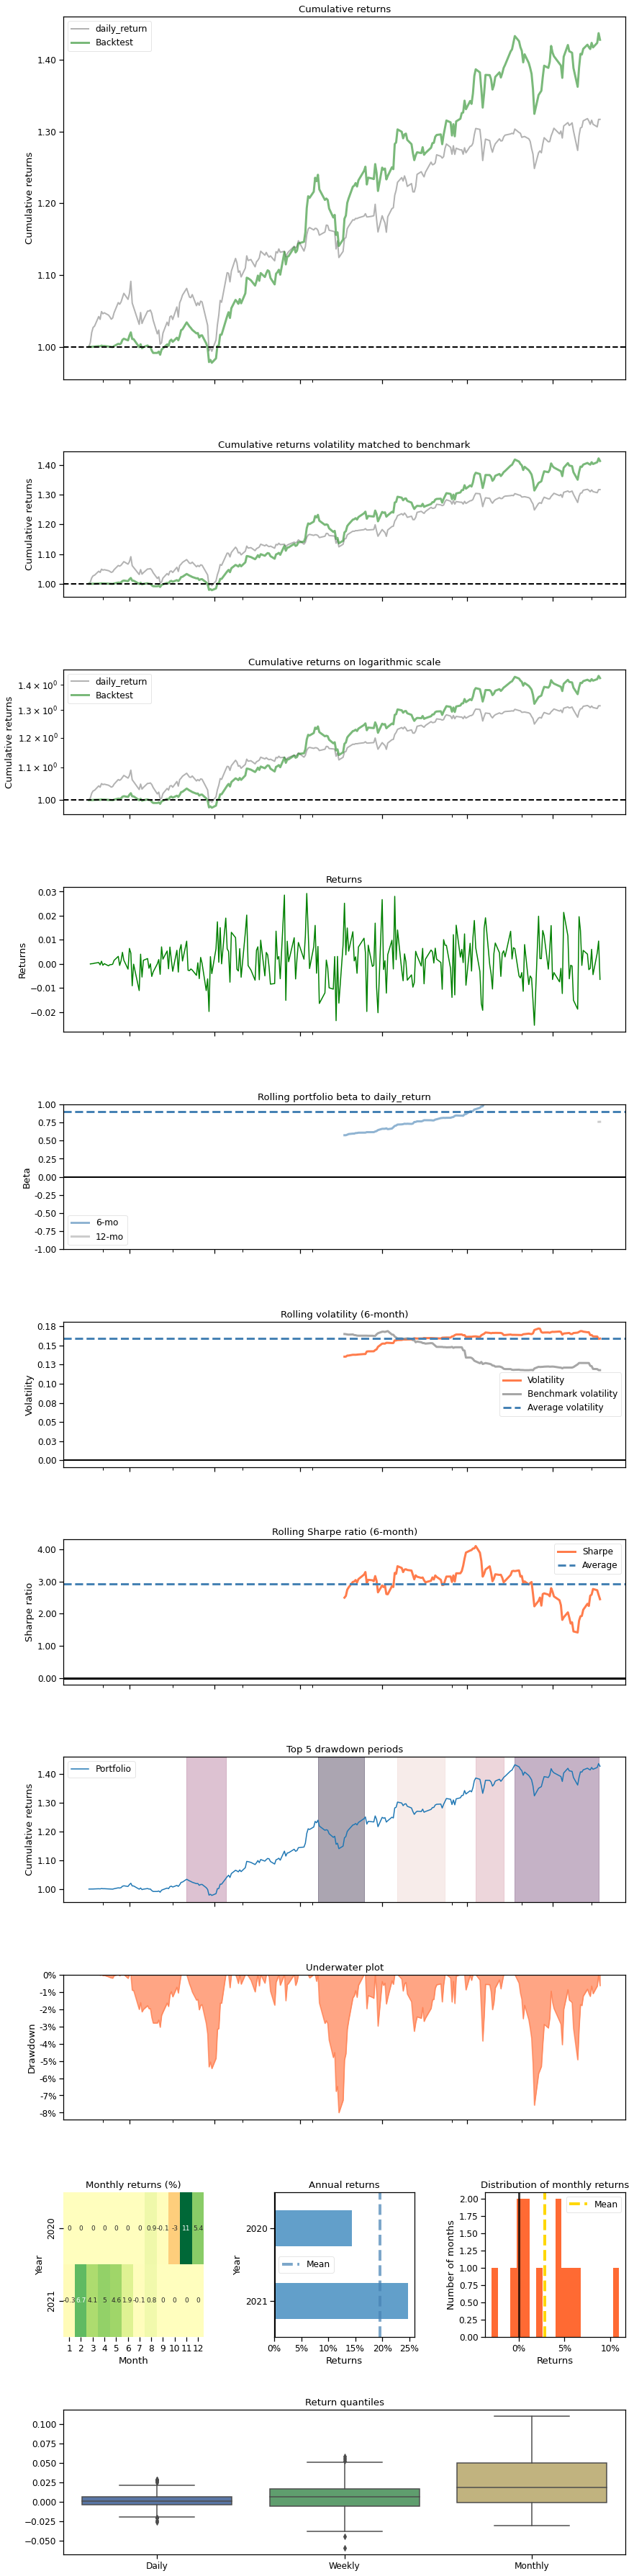

In [30]:
print("==============Compare to DJIA===========")
%matplotlib inline
# S&P 500: ^GSPC
# Dow Jones Index: ^DJI
# NASDAQ 100: ^NDX
backtest_plot(account_value_erl, 
             baseline_ticker = '^DJI', 
             baseline_start = account_value_erl.loc[0,'date'],
             baseline_end = account_value_erl.loc[len(account_value_erl)-1,'date'])

## RLlib

### Train

In [39]:
#demo for rllib
train(start_date = TRAIN_START_DATE, 
      end_date = TRAIN_END_DATE,
      ticker_list = config.DOW_30_TICKER, 
      data_source = 'yahoofinance',
      time_interval= '1D', 
      technical_indicator_list= TECHNICAL_INDICATORS_LIST,
      drl_lib='rllib', 
      env=env, 
      agent='ppo', 
      cwd='./test_ppo'
      ,total_episodes=30)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

2021-10-07 18:55:48,660	INFO worker.py:837 -- Calling ray.init() again after it has already been called.
2021-10-07 18:55:48,700	WARNING ppo.py:149 -- `train_batch_size` (2048) cannot be achieved with your other settings (num_workers=2 num_envs_per_worker=1 rollout_fragment_length=200)! Auto-adjusting `rollout_fragment_length` to 1024.


Successfully transformed into array


2021-10-07 18:55:59,968	WARNING trainer_template.py:186 -- `execution_plan` functions should accept `trainer`, `workers`, and `config` as args!
2021-10-07 18:55:59,971	INFO trainable.py:112 -- Trainable.setup took 11.273 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.


### Test

In [40]:
account_value_rllib = test(start_date = TEST_START_DATE, 
     end_date = TEST_END_DATE,
     ticker_list = config.DOW_30_TICKER, 
     data_source = 'yahoofinance',
     time_interval= '1D', 
     technical_indicator_list= TECHNICAL_INDICATORS_LIST,
     drl_lib='rllib', 
     env=env, 
     agent='ppo', 
     cwd='./test_ppo/checkpoint_000030/checkpoint-30')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

2021-10-07 19:01:24,080	WARNING trainer_template.py:186 -- `execution_plan` functions should accept `trainer`, `workers`, and `config` as args!
2021-10-07 19:01:24,095	INFO trainable.py:112 -- Trainable.setup took 11.786 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.
2021-10-07 19:01:24,219	INFO trainable.py:394 -- Restored on 172.28.0.2 from checkpoint: ./test_ppo/checkpoint_000030/checkpoint-30
2021-10-07 19:01:24,225	INFO trainable.py:401 -- Current state after restoring: {'_iteration': 30, '_timesteps_total': None, '_time_total': 249.51879978179932, '_episodes_total': 36}


Restoring from checkpoint path ./test_ppo/checkpoint_000030/checkpoint-30
episode return: 1.3504243769303437
Test Finished!


In [33]:
len(account_value_rllib)

255

### Plot

In [42]:
baseline_df =  DataProcessor('yahoofinance').download_data(ticker_list = ["^DJI"], 
                                                            start_date = TEST_START_DATE, 
                                                            end_date = TEST_END_DATE, 
                                                            time_interval = "1D")
stats = backtest_stats(baseline_df, value_col_name = 'close')


[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (254, 9)
Annual return          0.302105
Cumulative returns     0.304836
Annual volatility      0.143039
Sharpe ratio           1.925145
Calmar ratio           3.382743
Stability              0.935738
Max drawdown          -0.089308
Omega ratio            1.381054
Sortino ratio          2.847623
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.074665
Daily value at risk   -0.016928
dtype: float64


In [43]:
len(baseline_df.date)

254

In [44]:
account_value_rllib = pd.DataFrame({'date':baseline_df.date,'account_value':account_value_rllib[0:len(account_value_rllib)-1]})

In [45]:
perf_stats_all = backtest_stats(account_value=account_value_rllib)
perf_stats_all = pd.DataFrame(perf_stats_all)

Annual return          0.347325
Cumulative returns     0.350516
Annual volatility      0.164955
Sharpe ratio           1.897578
Calmar ratio           3.559365
Stability              0.901113
Max drawdown          -0.097581
Omega ratio            1.386491
Sortino ratio          2.909387
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.065581
Daily value at risk   -0.019540
dtype: float64


==============Compare to DJIA===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (253, 8)


Start date,2020-08-03
End date,2021-08-04
Total months,12
,Backtest
Annual return,34.732%
Cumulative returns,35.052%
Annual volatility,16.495%
Sharpe ratio,1.90
Calmar ratio,3.56
Stability,0.90
Max drawdown,-9.758%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,9.76,2020-09-02,2020-10-30,2020-11-09,49
1,5.73,2021-07-12,2021-07-19,NaT,NaN
2,4.63,2021-05-07,2021-05-19,2021-06-24,35
3,3.62,2021-01-08,2021-01-29,2021-02-05,21
4,3.16,2021-02-24,2021-02-26,2021-03-10,11


/usr/local/lib/python3.7/dist-packages/pyfolio/tears.py:907: UserWarning: Passed returns do not overlap with anyinteresting times.
  'interesting times.', UserWarning)


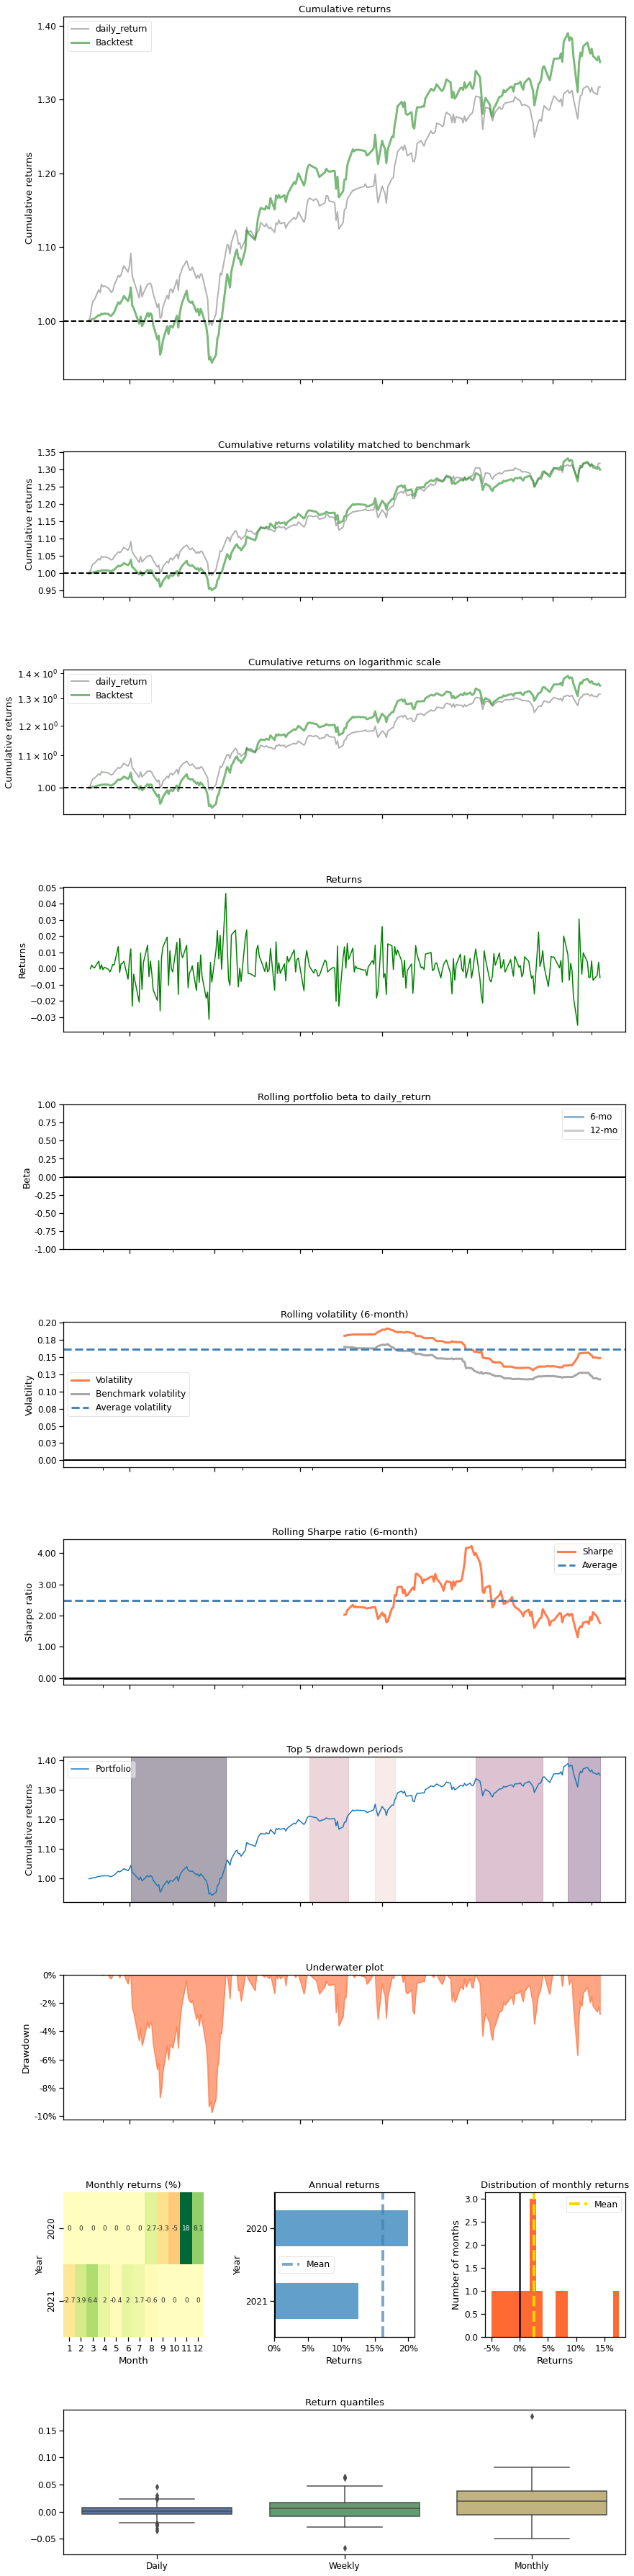

In [46]:
print("==============Compare to DJIA===========")
%matplotlib inline
# S&P 500: ^GSPC
# Dow Jones Index: ^DJI
# NASDAQ 100: ^NDX
backtest_plot(account_value_rllib, 
             baseline_ticker = '^DJI', 
             baseline_start = account_value_rllib.loc[0,'date'],
             baseline_end = account_value_rllib.loc[len(account_value_rllib)-1,'date'])

## Stable-baselines3

### Train

In [47]:
#demo for stable-baselines3
train(start_date = TRAIN_START_DATE, 
      end_date = TRAIN_END_DATE,
      ticker_list = config.DOW_30_TICKER, 
      data_source = 'yahoofinance',
      time_interval= '1D', 
      technical_indicator_list= TECHNICAL_INDICATORS_LIST,
      drl_lib='stable_baselines3', 
      env=env, 
      agent='ppo', 
      cwd='./test_ppo',
      total_timesteps=50000)


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

### Test

In [48]:
account_value_sb3=test(start_date = TEST_START_DATE, 
     end_date = TEST_END_DATE,
     ticker_list = config.DOW_30_TICKER, 
     data_source = 'yahoofinance',
     time_interval= '1D', 
     technical_indicator_list= TECHNICAL_INDICATORS_LIST, 
     drl_lib='stable_baselines3', 
     env=env, 
     agent='ppo', 
     cwd='./test_ppo.zip')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [49]:
len(account_value_sb3)

255

### Plot

In [50]:
baseline_df =  DataProcessor('yahoofinance').download_data(ticker_list = ["^DJI"], 
                                                            start_date = TEST_START_DATE, 
                                                            end_date = TEST_END_DATE, 
                                                            time_interval = "1D")
stats = backtest_stats(baseline_df, value_col_name = 'close')


[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (254, 9)
Annual return          0.302105
Cumulative returns     0.304836
Annual volatility      0.143039
Sharpe ratio           1.925145
Calmar ratio           3.382743
Stability              0.935738
Max drawdown          -0.089308
Omega ratio            1.381054
Sortino ratio          2.847623
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.074665
Daily value at risk   -0.016928
dtype: float64


In [51]:
account_value_sb3 = pd.DataFrame({'date':baseline_df.date,'account_value':account_value_sb3[0:len(account_value_sb3)-1]})

In [52]:
perf_stats_all = backtest_stats(account_value=account_value_sb3)
perf_stats_all = pd.DataFrame(perf_stats_all)

Annual return          0.301541
Cumulative returns     0.304267
Annual volatility      0.169634
Sharpe ratio           1.645015
Calmar ratio           3.114448
Stability              0.916821
Max drawdown          -0.096820
Omega ratio            1.314858
Sortino ratio          2.488486
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.005935
Daily value at risk   -0.020265
dtype: float64


In [53]:
account_value_sb3.tail()

,date,account_value
249,2021-07-29,1.322749e+06
250,2021-07-30,1.313299e+06
251,2021-08-02,1.310496e+06
252,2021-08-03,1.313478e+06
253,2021-08-04,1.304267e+06


==============Compare to DJIA===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (253, 8)


Start date,2020-08-03
End date,2021-08-04
Total months,12
,Backtest
Annual return,30.154%
Cumulative returns,30.427%
Annual volatility,16.963%
Sharpe ratio,1.65
Calmar ratio,3.11
Stability,0.92
Max drawdown,-9.682%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,9.68,2020-09-02,2020-10-28,2020-11-10,50
1,7.14,2021-06-04,2021-06-18,2021-07-12,27
2,6.62,2021-01-21,2021-01-29,2021-02-12,17
3,6.00,2021-07-12,2021-07-19,NaT,NaN
4,3.97,2021-05-07,2021-05-12,2021-06-01,18


/usr/local/lib/python3.7/dist-packages/pyfolio/tears.py:907: UserWarning: Passed returns do not overlap with anyinteresting times.
  'interesting times.', UserWarning)


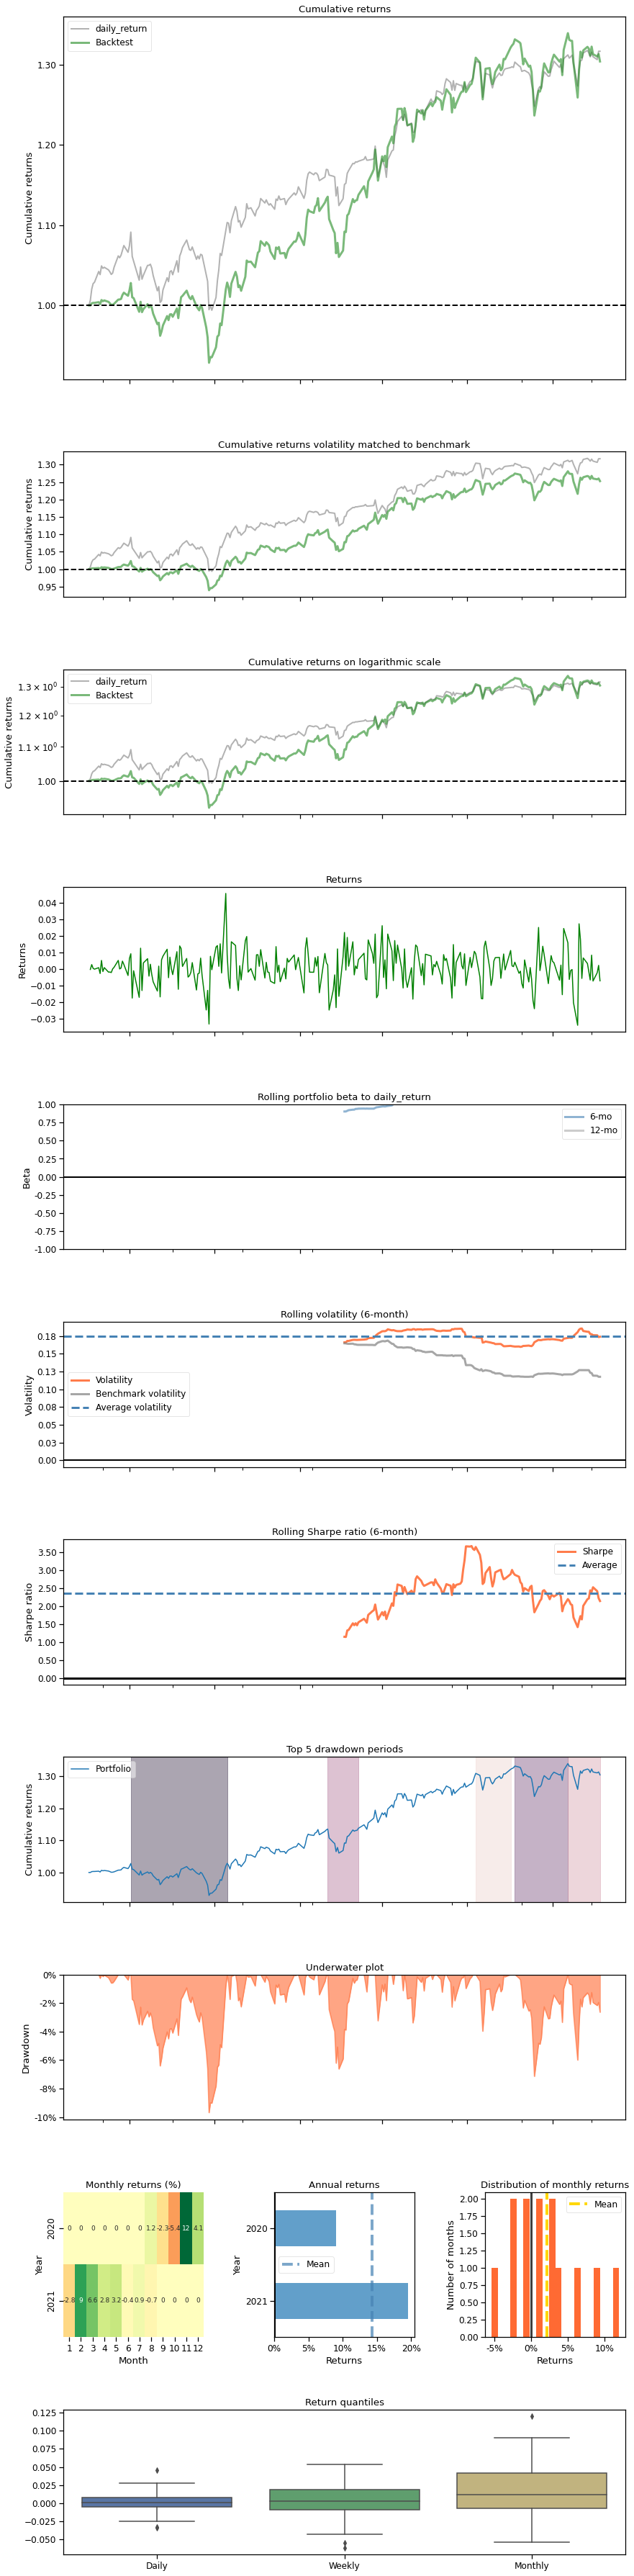

In [54]:
print("==============Compare to DJIA===========")
#%matplotlib inline
# S&P 500: ^GSPC
# Dow Jones Index: ^DJI
# NASDAQ 100: ^NDX
backtest_plot(account_value_sb3, 
             baseline_ticker = '^DJI', 
             baseline_start = account_value_sb3.loc[0,'date'],
             baseline_end = account_value_sb3.loc[len(account_value_sb3)-1,'date'])

## Plotly

In [55]:
baseline_df

,date,open,high,low,close,adjcp,volume,tic,day
0,2020-08-03,26542.320312,26707.259766,26534.380859,26664.400391,26664.400391,439380000,^DJI,0
1,2020-08-04,26664.609375,26832.720703,26597.820312,26828.470703,26828.470703,346350000,^DJI,1
2,2020-08-05,26924.779297,27221.669922,26924.779297,27201.519531,27201.519531,366000000,^DJI,2
3,2020-08-06,27170.820312,27394.099609,27145.250000,27386.980469,27386.980469,322460000,^DJI,3
4,2020-08-07,27321.679688,27456.240234,27223.550781,27433.480469,27433.480469,321170000,^DJI,4
...,...,...,...,...,...,...,...,...,...
249,2021-07-29,34985.988281,35171.519531,34985.988281,35084.531250,35084.531250,222680000,^DJI,3
250,2021-07-30,35013.261719,35106.300781,34871.128906,34935.468750,34935.468750,276410000,^DJI,4
251,2021-08-02,34968.558594,35192.109375,34808.199219,34838.160156,34838.160156,238620000,^DJI,0
252,2021-08-03,34864.101562,35120.941406,34714.328125,35116.398438,35116.398438,259820000,^DJI,1


In [56]:
from datetime import datetime as dt

import matplotlib.pyplot as plt
import plotly
import plotly.graph_objs as go

In [57]:
account_value_rllib.head()

,date,account_value
0,2020-08-03,1.000000e+06
1,2020-08-04,9.998664e+05
2,2020-08-05,1.002027e+06
3,2020-08-06,1.002781e+06
4,2020-08-07,1.003226e+06


In [58]:
daily_return = account_value_sb3.copy()
daily_return['sb3_return'] = account_value_sb3.account_value.pct_change()
daily_return['erl_return'] = account_value_erl.account_value.pct_change()
daily_return['rllib_return'] = account_value_rllib.account_value.pct_change()
daily_return['djia_return'] = baseline_df.adjcp.pct_change()


In [59]:
daily_return.head()

,date,account_value,sb3_return,erl_return,rllib_return,djia_return
0,2020-08-03,1.000000e+06,NaN,NaN,NaN,NaN
1,2020-08-04,9.998329e+05,-0.000167,-0.000019,-0.000134,0.006153
2,2020-08-05,1.002593e+06,0.002761,0.000087,0.002160,0.013905
3,2020-08-06,1.003064e+06,0.000470,0.000132,0.000753,0.006818
4,2020-08-07,1.003083e+06,0.000019,0.000293,0.000443,0.001698


In [60]:
daily_return.to_csv('daily_return_erl_sb3_rllib.csv',index=False)
#daily_return = pd.read_csv('daily_return_erl_sb3_rllib.csv')

In [61]:
rllib_cumpod =(daily_return.rllib_return+1).cumprod()-1
sb3_cumpod =(daily_return.sb3_return+1).cumprod()-1
erl_cumpod =(daily_return.erl_return+1).cumprod()-1
dji_cumpod =(daily_return.djia_return+1).cumprod()-1

In [62]:
time_ind = pd.Series(daily_return.date)

In [63]:
trace0_portfolio = go.Scatter(x = time_ind, y = rllib_cumpod, mode = 'lines', name = 'RLlib')

trace1_portfolio = go.Scatter(x = time_ind, y = dji_cumpod, mode = 'lines', name = 'DJIA')
trace2_portfolio = go.Scatter(x = time_ind, y = sb3_cumpod, mode = 'lines', name = 'Stablebaselines3')
trace3_portfolio = go.Scatter(x = time_ind, y = erl_cumpod, mode = 'lines', name = 'ElegantRL')
#trace4_portfolio = go.Scatter(x = time_ind, y = addpg_cumpod, mode = 'lines', name = 'Adaptive-DDPG')
#trace5_portfolio = go.Scatter(x = time_ind, y = min_cumpod, mode = 'lines', name = 'Min-Variance')

#trace4 = go.Scatter(x = time_ind, y = addpg_cumpod, mode = 'lines', name = 'Adaptive-DDPG')

#trace2 = go.Scatter(x = time_ind, y = portfolio_cost_minv, mode = 'lines', name = 'Min-Variance')
#trace3 = go.Scatter(x = time_ind, y = spx_value, mode = 'lines', name = 'SPX')

In [64]:
fig = go.Figure()
fig.add_trace(trace0_portfolio)

#fig.add_trace(trace1_portfolio)

#fig.add_trace(trace2_portfolio)



fig.update_layout(
    legend=dict(
        x=0,
        y=1,
        traceorder="normal",
        font=dict(
            family="sans-serif",
            size=15,
            color="black"
        ),
        bgcolor="White",
        bordercolor="white",
        borderwidth=2
        
    ),
)
#fig.update_layout(legend_orientation="h")
fig.update_layout(title={
        #'text': "Cumulative Return using FinRL",
        'y':0.85,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
#with Transaction cost
#fig.update_layout(title =  'Quarterly Trade Date')
fig.update_layout(
#    margin=dict(l=20, r=20, t=20, b=20),

    paper_bgcolor='rgba(1,1,0,0)',
    plot_bgcolor='rgba(1, 1, 0, 0)',
    #xaxis_title="Date",
    yaxis_title="Cumulative Return",
xaxis={'type': 'date', 
       'tick0': time_ind[0], 
        'tickmode': 'linear', 
       'dtick': 86400000.0 *80}

)
fig.update_xaxes(showline=True,linecolor='black',showgrid=True, gridwidth=1, gridcolor='LightSteelBlue',mirror=True)
fig.update_yaxes(showline=True,linecolor='black',showgrid=True, gridwidth=1, gridcolor='LightSteelBlue',mirror=True)
fig.update_yaxes(zeroline=True, zerolinewidth=1, zerolinecolor='LightSteelBlue')

fig.show()